# Initially

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain-groq langchain_core langgraph

In [47]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [50]:
def node_1(state):
    print("---Node 1---")
    return {
        'graph_state': state['graph_state'] + ' HERO'
    }

def node_2(state):
    print("---Node 2---")
    return {
        'graph_state': state['graph_state'] + ' ZERO'
    }

def node_3(state):
    print("---Node 3---")
    return {
        'graph_state': state['graph_state'] + ' BANTU'
    }

In [52]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

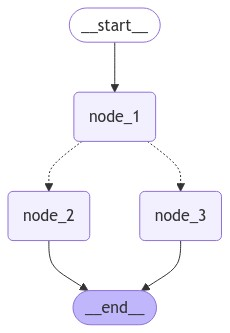

In [59]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
graph.invoke({"graph_state" : "Hi, this is Kousik."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Kousik. HERO ZERO'}

# Agent / Chain / Router / Memory

## Chain

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [4]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file


In [6]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

In [20]:
from langchain_groq import ChatGroq
CHAT_MODEL_NAME = "llama-3.1-70b-versatile"
llm = ChatGroq(model=CHAT_MODEL_NAME)

In [52]:
result = llm.invoke(messages)
print(type(result))
print('\n\n')
print(result)

<class 'langchain_core.messages.ai.AIMessage'>



content='The United States offers several locations to spot Orcas (also known as killer whales) in their natural habitat. Here are some of the best places to see Orcas in the US:\n\n1. **Puget Sound, Washington**: This is one of the most reliable places to see Orcas in the US. The Southern Resident population, which is an endangered population, can be found in the waters around Seattle, particularly in the San Juan Islands and Puget Sound.\n2. **San Juan Islands, Washington**: This archipelago is a popular spot for Orca whale watching, with several tour operators offering guided tours.\n3. **Olympic National Park, Washington**: The coastal waters of Olympic National Park are home to a large population of Orcas.\n4. **Alaska**: Alaska is home to a large population of Orcas, particularly in the waters around Seward, Juneau, and Icy Strait.\n5. **Monterey Bay, California**: While not as common as in the Pacific Northwest, Orcas can be spot

In [57]:
result.response_metadata

{'token_usage': {'completion_tokens': 335,
  'prompt_tokens': 91,
  'total_tokens': 426,
  'completion_time': 1.34,
  'prompt_time': 0.016624181,
  'queue_time': 0.003510777000000003,
  'total_time': 1.356624181},
 'model_name': 'llama-3.1-70b-versatile',
 'system_fingerprint': 'fp_b3ae7e594e',
 'finish_reason': 'stop',
 'logprobs': None}

In [61]:
result.pretty_print()

================================== Ai Message ==================================

The United States offers several locations to spot Orcas (also known as killer whales) in their natural habitat. Here are some of the best places to see Orcas in the US:

1. **Puget Sound, Washington**: This is one of the most reliable places to see Orcas in the US. The Southern Resident population, which is an endangered population, can be found in the waters around Seattle, particularly in the San Juan Islands and Puget Sound.
2. **San Juan Islands, Washington**: This archipelago is a popular spot for Orca whale watching, with several tour operators offering guided tours.
3. **Olympic National Park, Washington**: The coastal waters of Olympic National Park are home to a large population of Orcas.
4. **Alaska**: Alaska is home to a large population of Orcas, particularly in the waters around Seward, Juneau, and Icy Strait.
5. **Monterey Bay, California**: While not as common as in the Pacific Northwest, 

In [68]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [71]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_brvf', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 232, 'total_tokens': 251, 'completion_time': 0.076, 'prompt_time': 0.106593249, 'queue_time': -0.009266431000000006, 'total_time': 0.182593249}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1768f36b-2d01-4971-8daf-b3e4c5879a04-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_brvf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 232, 'output_tokens': 19, 'total_tokens': 251})

In [85]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

#### Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [110]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [113]:
messages_state = MessagesState()
?messages_state

Type:        dict
String form: {}
Length:      0
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [115]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [117]:
messages_state2 = MessagesState()
?messages_state2

Type:        dict
String form: {}
Length:      0
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [120]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='c9895766-8e57-4cbf-8873-00a3c2289058'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='6b2d8767-4f17-498f-abe8-01971badfb03'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='24d085cb-3d1b-4b58-8261-24508d1fae1c')]

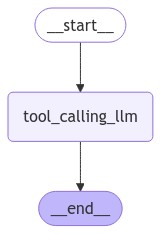

In [131]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

# Build Graph
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_llm',tool_calling_llm)

builder.add_edge(START,'tool_calling_llm')
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [139]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

I'm happy to help you. What would you like to multiply?


# Router

In [22]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b



In [24]:
from langchain_groq import ChatGroq
CHAT_MODEL_NAME = "llama-3.1-70b-versatile"
llm = ChatGroq(model=CHAT_MODEL_NAME)

llm_with_tools = llm.bind_tools([multiply])

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

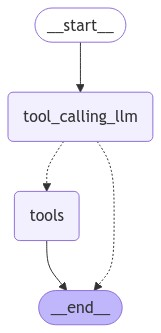

In [30]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

I don't have any function to call in this case, as we just started the conversation and no specific task was given. If you need help with something specific, feel free to ask, and I'll do my best to assist you.


In [39]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="3 multiply with 5 and then 7")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

3 multiply with 5 and then 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hds3)
 Call ID: call_hds3
  Args:
    a: 3
    b: 5
  multiply (call_m59b)
 Call ID: call_m59b
  Args:
    a: 15
    b: 7
================================= Tool Message =================================
Name: multiply

15
================================= Tool Message =================================
Name: multiply

105


# Agent

# Memory